# Problem Set 7

<span style="color:red">Warning!</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful! It my be useful to start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Preprocessing and  Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

First, display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images from your dataset? 

Now, remove all individuals for whom you have fewer than 10 images. How many individuals are you left with in the dataset?

In [207]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l1, l2


In [239]:
# access all image files
name_list = {}
num_list = {}

path = "/Users/catherineyu/lfw_funneled"
_, files,_ = next(os.walk(path))
for file in files:
        _, _ ,imgs = next(os.walk(path+ '/'+ file))
        name_list[file] = len(imgs)

        if len(imgs) in num_list:
                num_list[len(imgs)] += 1
        else:
                num_list[len(imgs)] = 0

print(len(name_list))

5749


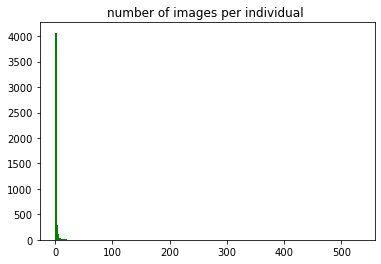

In [240]:
# number of images per individual 
plt.bar(list(num_list.keys()), num_list.values(), color='g', width=3)
plt.title('number of images per individual ')
plt.show()

In [246]:
# remove all individuals who have fewer than 10 images
new_name_list = {k: v for k, v in name_list.items() if v > 10}
print(len(new_name_list))

143


In [233]:
#find the individual with most images
a = {k: v for k, v in name_list.items() if v > 300}
a

{'George_W_Bush': 530}

* George_W_Bush has the most images from your dataset
* 143 individuals are left after remove all individuals have fewer than 10 images

### 1.2. Show some faces!

1. Pick 10 random images from the dataset and display them in a 2 x 5 grid.
2. This time pick 200 random images. Create a single image that shows the "average face" over this random sample -- i.e. each pixel should display the average value of that particular pixel across the random sample. 

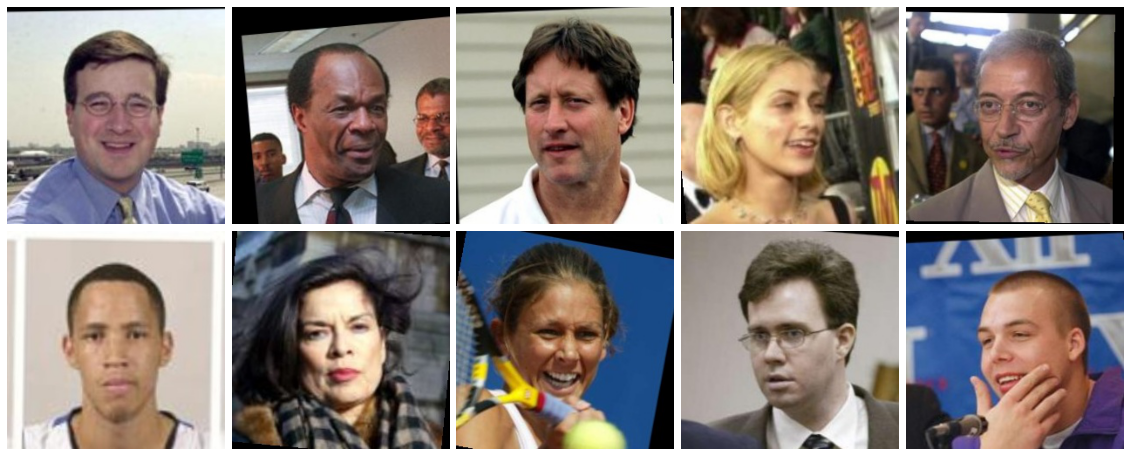

In [241]:
# Pick ten random pictures
n = len(files)

imglist = []
while len(imglist) < 10:
    folder = files[random.randint(0, n-1)]
    #pics = os.listdir(path + '/' + folder)
    temp = random.choice(os.listdir(path + '/' + folder))
    if temp in imglist:
        pass
    else:
        imglist.append(path + '/' + folder + '/' + temp)

def img_reshape(img):
    img = Image.open(img).convert('RGB') # 'RGB'
    #img = img.resize((300,300))
    imga = np.asarray(img)
    img.close()
    return imga

img_arr = []

for image in imglist:
    img_arr.append(img_reshape(image))

# plot grid
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)
    ax.axis('off')
    
    
plt.show()

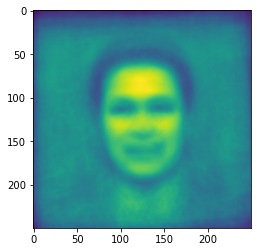

In [242]:
# pick 200 random pictures
n = len(files)

def img_reshape(img):
    img = Image.open(img).convert('L') # 'RGB'
    #img = color.gray2rgb(Image.open(img))
    imga = np.asarray(img)
    img.close()
    return imga

imglist = []
while len(imglist) < 200:
    folder = files[random.randint(0, n-1)]
    #pics = os.listdir(path + '/' + folder)
    temp = random.choice(os.listdir(path + '/' + folder))
    if temp in imglist:
        pass
    else:
        imglist.append(path + '/' + folder + '/' + temp)

img_arr = []

for image in imglist:
    img_arr.append(img_reshape(image))

# calculate average face
average_face = np.array(img_arr).mean(axis=0)

# show image
plt.imshow(average_face)
plt.show()

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [176]:
from sklearn.metrics.pairwise import pairwise_distances_argmin
#reference: https://analyticsarora.com/k-means-for-beginners-how-to-build-from-scratch-in-python/

# Your code here
def euclidien_dist(x, y): # calculate euclidean distance
      temp = list(map(lambda i, j : (i-j)**2, x, y))
      dist = np.sqrt(np.sum(temp))
      return dist

def InitializeCentroids(X, k): # random pick centroids
      idx = np.random.randint(0, len(X)-1, size=k)
      return X[idx,:]

def FindClosestCentroids(X, centroids): # decide clusters for each image
      order = pairwise_distances_argmin(X, centroids)
      return order

# calculate loss (sum of distances of the centriods and every points within that cluster) using euclidean distance
def ComputeLoss(X, centroids, clusters): 
      sum = 0
      for idx, val in enumerate(X):
            #sum += np.sqrt((centroids[clusters[idx], 0]-val[0])**2 +(centroids[clusters[idx], 1]-val[1])**2) #euclidien distance 
            sum += euclidien_dist(centroids[clusters[idx]], val)
      return sum

def NewCentroids(X, centroids, clusters): # calculate the average of the points in the clusters as new centroids 
      new_centroids = np.empty(centroids.shape)
      for i in range(centroids.shape[0]):
            new_centroids[i] = np.mean(X[clusters == i], axis = 0)
      return new_centroids

def ClosestPoint(X, centroids, clusters): # calculate the closest point to the centroids of each cluster
      closestp = np.empty(centroids.shape)
      for i in range(centroids.shape[0]):
            min_dist = euclidien_dist(centroids[i], X[clusters == i][0])
            p = np.empty(centroids[0].shape)
            for idx, val in enumerate(X[clusters == i]):
                  dist = euclidien_dist(centroids[i], val)
                  if dist < min_dist:
                        min_dist = dist
                        p = val
            closestp[i] = p
      return closestp        

def kmeans(X, k): #k-means clustering
  centroids = InitializeCentroids(X, k)
  clusters = FindClosestCentroids(X, centroids)
  loss = ComputeLoss(X, centroids, clusters)
  iter = 0

  while True:
    new_centroids = NewCentroids(X, centroids, clusters)
    new_clusters = FindClosestCentroids(X, new_centroids)
    new_loss = ComputeLoss(X, new_centroids, new_clusters)

    diff = np.abs(new_loss - loss)
    if diff < 0.00001:
            break
    loss = new_loss
    centroids = new_centroids
    clusters = new_clusters
    iter += 1

  closestpoints = ClosestPoint(X, centroids, clusters)
    
  return clusters, centroids, loss, closestpoints

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. Also create a scatterplot that shows these datapoints, colored by cluster. 

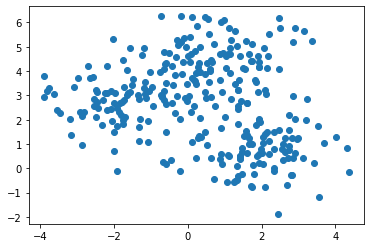

In [145]:
from sklearn.datasets import make_blobs, load_boston, load_digits

# Your code here
# Generate isotropic Gaussian blobs for clustering.
# See: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
x, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=1, random_state=0)

# Plot synthetic data
plt.scatter(x[:, 0], x[:, 1])
plt.show()

In [177]:
#run kmeans
clusters, centroids, loss, closestpoints = kmeans(x, 3)

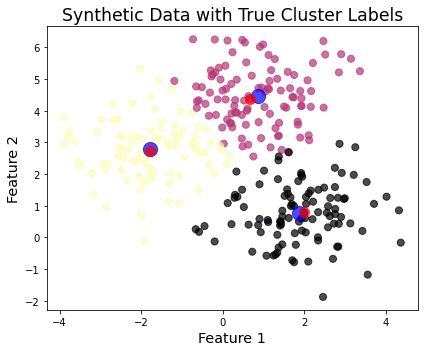

In [178]:
# Plot synthetic data
fig, ax = plt.subplots(1, figsize=(6, 5))
ax.scatter(x[:, 0], x[:, 1], c=clusters, s=50, cmap='magma',alpha=0.7)

# plot cluster centers
ax.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=200, alpha=0.7)

# plot nearest points
ax.scatter(closestpoints[:, 0], closestpoints[:, 1], c='red', s=100, alpha=0.7)

# Clean up plot
ax.set_title('Synthetic Data with True Cluster Labels', fontsize='xx-large')
ax.set_xlabel('Feature 1', fontsize='x-large')
ax.set_ylabel('Feature 2', fontsize='x-large')
plt.tight_layout()
plt.show()

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=10. Make sure to standardize your data first! Show a 10 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250x250x3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is -- it might take a long time for your algorithm to converge. If your computer is slow, it might even take a very long time for you to simply standardize your data. We recommend you convert your RGB images into grayscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function, or any other way to convert to graysacle) before standardizing.



In [195]:
#1000 random pics from the dataset
n = len(files)

def img_reshape(img):
    img = Image.open(img).convert('L') # 'RGB'
    #img = color.gray2rgb(Image.open(img))
    imga = np.asarray(img)
    img.close()
    return imga

imglist = []
while len(imglist) < 1000:
    folder = files[random.randint(0, n-1)]
    #pics = os.listdir(path + '/' + folder)
    temp = random.choice(os.listdir(path + '/' + folder))
    if temp in imglist:
        pass
    else:
        imglist.append(path + '/' + folder + '/' + temp)

img_arr = []

for image in imglist:
    img_arr.append(img_reshape(image))

In [196]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

# standardize
img_arr = standardize(img_arr)
rndImg2 = np.reshape(img_arr, (img_arr.shape[0], img_arr.shape[1]*img_arr.shape[2]))

#kmeans clustering
k = 10
clusters, centroids, loss, closestpoints = kmeans(rndImg2, k)

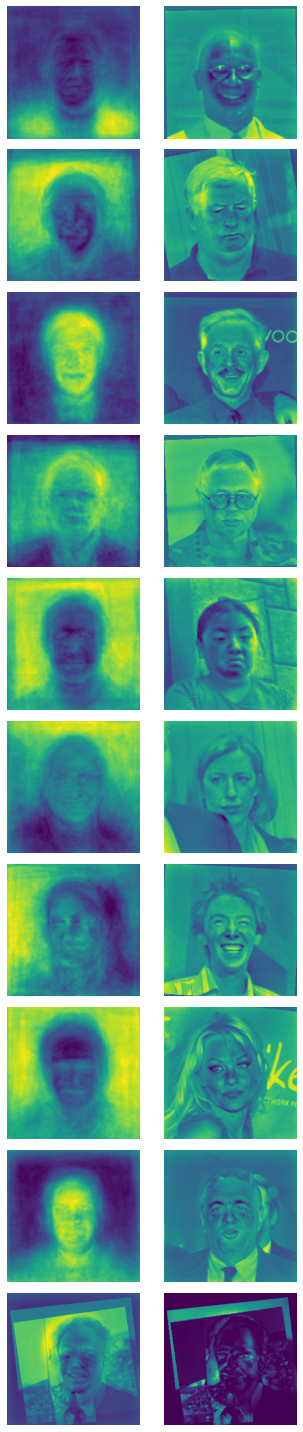

In [199]:
#reshape image
centroids_reshape = centroids.reshape(centroids.shape[0], img_arr.shape[1], img_arr.shape[2])
cloest_reshape = closestpoints.reshape(centroids.shape[0], img_arr.shape[1], img_arr.shape[2])

#plot grid
fig, axarr = plt.subplots(k,2, figsize=(5, 20))
for i in range(k):
    axarr[i,0].imshow(centroids_reshape[i])
    axarr[i,0].axis('off')
    axarr[i,1].imshow(cloest_reshape[i])
    axarr[i,1].axis('off')

fig.tight_layout()
plt.show()


The centroids look very vague, probably due to the relatively small data.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself.
 2. The cluster centroid closest to that image.
 3. The closest image in the dataset to that cluster centroid.
 4. The closest image in the dataset to the image of yourself.


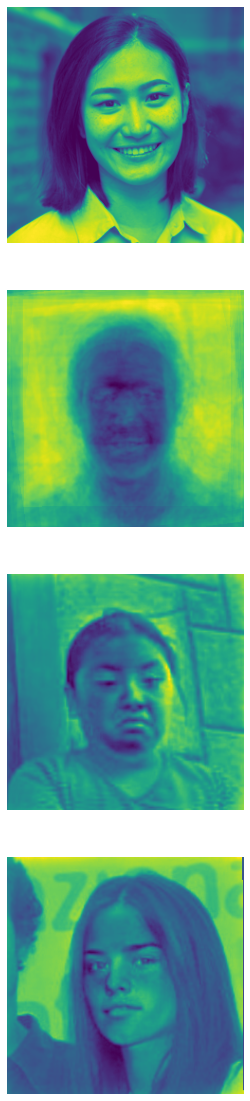

In [228]:
fig, ax = plt.subplots(4,1, figsize=(5, 20))

# the image of yourself
img = Image.open('/Users/catherineyu/Desktop/MIMS/info 251/assignment/PS7/myimg.jpg').convert('L') # 'RGB'
img = img.resize((250, 250))
myimg = np.asarray(img)
img.close()
ax[0].imshow(myimg)
ax[0].axis('off')

# closest cluster centroid
myimg_r = myimg.reshape(img_arr.shape[1]*img_arr.shape[2])
min_dist = euclidien_dist(centroids[0], myimg_r)
min_idx = 0
for idx, val in enumerate(centroids):
    dist = euclidien_dist(myimg_r, val)
    if dist < min_dist:
        min_dist = dist
        min_idx = idx
ax[1].imshow(centroids_reshape[min_idx])
ax[1].axis('off')

# The closest image in the dataset to that cluster centroid.
ax[2].imshow(cloest_reshape[min_idx])
ax[2].axis('off')

# The closest image in the dataset to the image of yourself.
x_myimg_clus = rndImg2[clusters == min_idx]
min_dist = euclidien_dist(x_myimg_clus[0], myimg_r)
min_idx = 0
for idx, val in enumerate(x_myimg_clus):
    dist = euclidien_dist(myimg_r, val)
    if dist < min_dist:
        min_dist = dist
        min_idx = idx
#a = x_myimg_clus.reshape(x_myimg_clus.shape[0], img_arr.shape[1], img_arr.shape[2])
#ax[3].imshow(a[min_idx])
ax[3].imshow(img_arr[min_idx])
ax[3].axis('off')

#show grid
plt.show()


### 2.5. (Extra credit): k-Means++
- In 2.1 you implemented k-Means clustering with random initialization of the centroids. In this part implement the k-Means++ version of the algorithm that uses a "smarter" initialization of the centroids in order to achieve faster convergence. Compare the number of iterations it took k-Means in 2.3 to converge with random initialization to the number of iterations it takes k-Means++. Also compare the sum of squared errors that you obtain for both methods. Use for both k=20 clusters. The following link shows the paper that proposed k-Means++.
http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

In [ ]:
# Your code here

*Your comments here*

## 3. PCA and Eigenfaces 

Ensure you are using standardized data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [236]:
# standardize
img_arr = standardize(img_arr)
rndImg2 = np.reshape(img_arr, (img_arr.shape[0], img_arr.shape[1]*img_arr.shape[2]))

# split train & test
np.random.seed(seed=13579)

# split train test set
train_percent = .80
train_number = int(train_percent*rndImg2.shape[0])
print('Total examples: %i' % rndImg2.shape[0])
print('Number of training examples: %i' % train_number)
print('Number of testing examples: %i' % (rndImg2.shape[0] - train_number))

ids = np.arange(0, rndImg2.shape[0], 1)
ids = np.random.permutation(ids)
df_shuffled = rndImg2[ids]

df_train = df_shuffled[:train_number]
df_test = df_shuffled[train_number:]

Total examples: 1001
Number of training examples: 800
Number of testing examples: 201


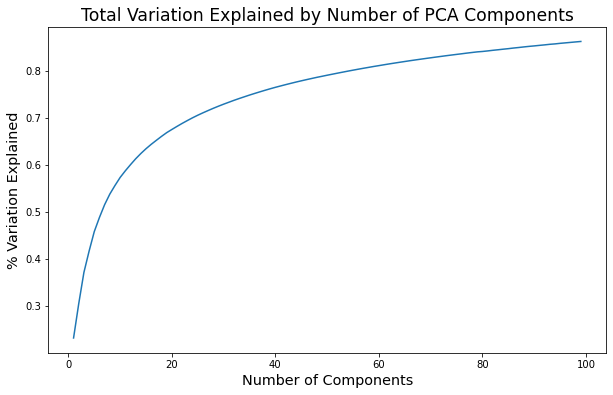

In [243]:
# run pca
variation_explained = []
n_components = range(1, 100)
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(df_train)
    variation_explained.append(np.sum(pca.explained_variance_ratio_))
    
# Plot
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(n_components, variation_explained)
ax.set_title('Total Variation Explained by Number of PCA Components', fontsize='xx-large')
ax.set_xlabel('Number of Components', fontsize='x-large')
ax.set_ylabel('% Variation Explained', fontsize='x-large')
plt.show()

In [277]:
# How many components are required to explain 75% of the variation in your original data?
n75 = np.array(n_components)[np.array(variation_explained) > 0.75][0] 
print('Number of components required to explain 75 percent of the variation = %d' %n75)

Number of components required to explain 75 percent of the variation = 36


* 36 of components are required to explain 75 percent of the variation 

### 3.2. The Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

In [319]:
#extract 10 principal components
print(pca.components_[:10])

[[ 2.81008391e-03  2.89208652e-03  3.02218171e-03 ...  1.64319978e-03
   1.48527781e-03  1.49644218e-03]
 [-8.59596298e-04 -1.00852952e-03 -1.12706119e-03 ... -4.70831534e-03
  -4.50842423e-03 -4.38275854e-03]
 [-2.41217772e-03 -2.47103000e-03 -2.45857771e-03 ...  2.72399511e-03
   2.70763018e-03  2.66193287e-03]
 ...
 [-4.93569872e-03 -5.05299349e-03 -5.06598757e-03 ... -6.84540735e-03
  -6.99521648e-03 -6.69112406e-03]
 [-3.37980369e-03 -3.16243831e-03 -3.41784013e-03 ... -4.50431254e-04
  -5.32514145e-05  4.03467735e-04]
 [ 2.03804528e-03  2.10712205e-03  2.57932830e-03 ...  3.88024136e-03
   4.08044693e-03  3.75234863e-03]]


### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 40-dimensional space defined by the first 40 principal components.
 - Apply k-means clustering, with k=16, to the 40-dimensional projections of the training data. 
 - Display a 4 x 4 grid of images that shows what each of the 16 centroids look like after the centroid is projected back into the original-image space.

In [310]:
# project data
df_train_project = pca.transform(df_train)  #https://gtraskas.github.io/post/ex7/
fortypc = df_train_project[:, :40] #extract 40 pc

#kmeans clustering
k =16
clusters, centroids, loss, closestpoints = kmeans(fortypc, k)

In [362]:
#inverse project
X_inv_proj = pca.inverse_transform(df_train_project)

#calculating centroids: recompute the mean in the original space using the inverse projection data and the cluster labels 
centroids_invproject = np.zeros((k, X_inv_proj.shape[1]))
for label in range(len(centroids)):
    centroids_invproject[label] = (X_inv_proj[clusters == label].mean(0))


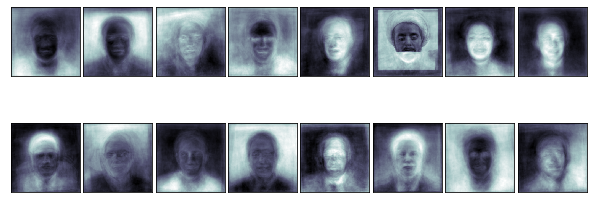

In [363]:
#grid
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(k):
    ax = fig.add_subplot(5, 8, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(centroids_invproject[i,:], (250,250)), cmap=plt.cm.bone, interpolation='nearest')

### 3.4. (Extra Credit): Recognition

Create a set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 40-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 40-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

Post the five images corresponding to your headshot on piazza to share with the rest of the class.

In [ ]:
# Your code here

# 4. Deep Learning

### 4.1 Data preprocessing
1. For this problem, filter to images associated with people that have at least 100 images in the dataset. Use the color version of the images (not grayscale). We'll use this dataset for a supervised multiclass classification problem, classifying which person each image is. How many classes (people) are there? How many observations (images) are there total?

2. Divide the reduced dataset into 50% train and 50% test. Standardize the data.

In [188]:
# filter to images associated with people that have at least 100 images in the dataset
name_list = {}
path = "/Users/catherineyu/lfw_funneled"
_, files,_ = next(os.walk(path))
for file in files:
        _, _ ,imgs = next(os.walk(path+ '/'+ file))
        name_list[file] = len(imgs)
new_name_list = {k: v for k, v in name_list.items() if v > 100}

# image list
imglist = []
target = []
for folder in new_name_list.keys():
    _, _ ,imgs = next(os.walk(path+ '/'+ folder))
    for im in imgs:
        imglist.append(path + '/' + folder + '/' + im)
        target.append(folder)

# open image
def img_reshape(img):
    img = Image.open(img).convert('RGB') # 'RGB'
    #img = img.resize((300,300))
    imga = np.asarray(img)
    img.close()
    return imga

img_arr = []

for image in imglist:
    img_arr.append(img_reshape(image))


img_arr = np.array(img_arr) 
rndImg2 = np.reshape(img_arr, (img_arr.shape[0], img_arr.shape[1]*img_arr.shape[2]*img_arr.shape[3]))

#add target
#ca = np.array(target)[..., None] #row vector to col vector
#df = np.append(rndImg2, ca, axis=1)
df = pd.DataFrame(rndImg2)
df['target'] = target
cleanup_nums = {"target": {"Gerhard_Schroeder": 0, "Tony_Blair": 1, "Donald_Rumsfeld": 2, "Colin_Powell": 3,
                                  "George_W_Bush": 4}}
df = df.replace(cleanup_nums) #https://pbpython.com/categorical-encoding.html


# split train test
train, test = train_test_split(df, shuffle=True, test_size=0.5, random_state=0)
#x_train, y_train = np.delete(train, -1, axis=1), train[:, -1]
#x_train, y_train = np.delete(test, -1, axis=1), test[:, -1]
x_train, y_train = train, train['target']
x_test, y_test = test, test['target']

# standardize data    
x_train = standardize(train)
x_test = standardize(test)

#drop target y from x
x_train = x_train.drop('target', axis=1)
x_test = x_test.drop('target', axis=1)

print('Total examples: %i' % rndImg2.shape[0])
print('Number of training examples: %i' % train.shape[0])
print('Number of testing examples: %i' % test.shape[0])


Total examples: 1140
Number of training examples: 570
Number of testing examples: 570


* Only 5 individuals are left after remove all individuals have fewer than 10 images
* 1140 images in total

### 4.2 Naive baseline
As a naive baseline method to compare to, create a random ordering of the labels in the training set and the test set. Report the overall classification accuracy for the shuffled labels in comparison to the true labels. Also report the true positive rate for each class. This random baseline represents a naive classifier that guesses randomly among the classes. What do you notice about the differences in precision and recall across classes?

In [203]:
# create a random ordering of the labels in the training set and the test set.
sam = np.linspace(0, 4, 5, dtype=int)

# oversampling from 0 to 4
random_lab_xtrain = []
for i in range(len(x_train)):
    random_lab_xtrain.append(random.choice(sam))

random_lab_xtest = []
for i in range(len(x_test)):
    random_lab_xtest.append(random.choice(sam))

# overall accuracy
print('Accuracy on training set: %.4f' % metrics.accuracy_score(y_train, random_lab_xtrain))
print('Accuracy on test set: %.4f' % metrics.accuracy_score(y_test, random_lab_xtest))

# recall
print('Recall on training set: %s' % metrics.recall_score(y_train, random_lab_xtrain, average=None))
print('Recall on test set: %s' % metrics.recall_score(y_test, random_lab_xtest, average=None))

# precision
print('Precision on training set: %s' % metrics.precision_score(y_train, random_lab_xtrain, average=None))
print('Precision on test set: %s' % metrics.precision_score(y_test, random_lab_xtest, average=None))

Accuracy on training set: 0.2228
Accuracy on test set: 0.1807
Recall on training set: [0.25       0.24324324 0.25862069 0.25210084 0.19101124]
Recall on test set: [0.22807018 0.14285714 0.23809524 0.17948718 0.16730038]
Precision on training set: [0.11206897 0.16071429 0.12396694 0.28301887 0.44347826]
Precision on test set: [0.12037037 0.08130081 0.1171875  0.19444444 0.42718447]


the accuracy is around 20%, which makes sense for a random classifier with 5 classes.

### 4.3 Feed forward neural network
Reshape your X data so that each observation is flattened into a 1d array, and each of the training and test matrices are 2d arrays. The shape of your data should be n_observations X 187,500. Train a fully connected neural network to predict which class each observation is in. The input_dimensions of your network will be 187,500 for each of the 187,500 "features" obtained from the flattened images. You are responsible for determining the structure of the network, the activiation functions, regularization, and optmization techniques. Ensure that your network exceeds 70% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the naive baseline?

*Hint: If you're not sure where to start, consider revisiting labs 8 and 10.*

In [237]:
# Your code here
# One hot encode the y variable
y_train_dummies = pd.get_dummies(y_train)
y_test_dummies = pd.get_dummies(y_test)

# Random seeds
np.random.seed(1)
tf.random.set_seed(1)

# Define NN
model = Sequential()
model.add(Dense(20, input_dim=len(x_train.columns), activation='relu')) # First layer defines input_dim
model.add(Dense(20, activation='relu')) # First layer defines input_dim
model.add(Dense(len(y_train_dummies.columns), activation='sigmoid')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [254]:
model = Sequential()
model.add(Dense(120, activation='relu', input_dim=len(x_train.columns))) #input_dim = number of input features
model.add(Dense(60, activation='relu'))
model.add(Dense(len(y_train_dummies.columns), activation='sigmoid')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [255]:
# Fit and predict with NN
model.fit(x_train, y_train_dummies, epochs=50, batch_size=10, verbose=0)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

# Convert probabilities to categorical predictions
yhat_train = np.argmax(yhat_train, axis=1)
yhat_test = np.argmax(yhat_test, axis=1)

# Get metrics
print('Accuracy on training set: %.2f' % metrics.accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.2f' % metrics.accuracy_score(y_test, yhat_test))

# Recall
print('Recall on training set: %s' % metrics.recall_score(y_train, yhat_train, average=None))
print('Recall on test set: %s' % metrics.recall_score(y_test, yhat_test, average=None))

# precision
print('Precision on training set: %s' % metrics.precision_score(y_train, yhat_train, average=None))
print('Precision on test set: %s' % metrics.precision_score(y_test, yhat_test, average=None))

Accuracy on training set: 0.74
Accuracy on test set: 0.58
Recall on training set: [1.         0.82432432 0.93103448 0.78151261 0.59925094]
Recall on test set: [0.87719298 0.74285714 0.50793651 0.5982906  0.4904943 ]
Precision on training set: [0.7027027  0.36094675 0.84375    0.90291262 1.        ]
Precision on test set: [0.63291139 0.27083333 0.57142857 0.73684211 0.87162162]


* The accuracy is higher than the naive baseline (accuracy on training set: 0.74 and accuracy on test set: 0.58).
* Overall the recalls are higher than precisions

### 4.4 Convolutional neural network

Now, train a convolutional neural network to predict which person is in each image. As above, you are in charge of all design parameters for the network, including convolutional filters, pooling layers, regularization, and optimization. Ensure that your CNN achieves over 80% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the feed forward neural network and naive baseline?

*Hint: If you're not sure where to start, consider revisiting lab 10.*

In [216]:
# reshape back to (250, 250, 3)
x_train_nf = np.array(x_train).reshape(x_train.shape[0], img_arr.shape[1], img_arr.shape[2], img_arr.shape[3])
x_test_nf = np.array(x_test).reshape(x_test.shape[0], img_arr.shape[1], img_arr.shape[2], img_arr.shape[3])

In [230]:
#define CNN
model = Sequential() #https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
model.add(Flatten(input_shape=x_train_nf.shape[1:])) 
model.add(Dense(100, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(len(y_train_dummies.columns), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 


In [231]:
#fit model
model.fit(x_train_nf, y_train_dummies, epochs=100, batch_size=30, verbose=0)
yhat_train = model.predict(x_train_nf)
yhat_test = model.predict(x_test_nf)

In [234]:
# Convert probabilities to categorical predictions
yhat_train = np.argmax(yhat_train, axis=1)
yhat_test = np.argmax(yhat_test, axis=1)

# Get metrics
print('Accuracy on training set: %.2f' % metrics.accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.2f' % metrics.accuracy_score(y_test, yhat_test))

# Recall
print('Recall on training set: %s' % metrics.recall_score(y_train, yhat_train, average=None))
print('Recall on test set: %s' % metrics.recall_score(y_test, yhat_test, average=None))

# precision
print('Precision on training set: %s' % metrics.precision_score(y_train, yhat_train, average=None))
print('Precision on test set: %s' % metrics.precision_score(y_test, yhat_test, average=None))

Accuracy on training set: 1.00
Accuracy on test set: 0.85
Recall on training set: [1.         1.         0.98275862 1.         1.        ]
Recall on test set: [0.84210526 0.74285714 0.57142857 0.91452991 0.91634981]
Precision on training set: [1.         1.         1.         1.         0.99626866]
Precision on test set: [0.81355932 0.82539683 0.7826087  0.80451128 0.89591078]


* accuracy on training set = 1.00, and accuracy on test set = 0.85
* Compared with the prior neural network and the naive baseline, the accuracy, recall, and precision are much higher. 